<a href="https://colab.research.google.com/github/enerhy/Portfolio/blob/master/U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Setup



In [1]:
pip install -q git+https://github.com/tensorflow/examples.git

In [0]:
%tensorflow_version 2.x
import tensorflow as tf

In [0]:
import tensorflow_datasets as tfds
# tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [0]:
import time 

In [5]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.1.0.incompleteUZFMYL/oxford_iiit_pet-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.1.0.incompleteUZFMYL/oxford_iiit_pet-test.tfrecord


Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.1.0. Subsequent calls will reuse this data.


In [6]:
# Get The Info
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.1.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.
',
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and J

# Preprocessing the Input - preparing the datasets 

In [7]:
# Check the keys and some values from the dataset
"""Note: to get an element out of the dict_values, we need to transform the
the dict into a list and than take the index"""

for i in dataset['train'].take(1):
  print(i.keys())
  print(list(i.values())[3].shape)
  print(tf.reduce_min(list(i.values())[3]))
  print(tf.reduce_max(list(i.values())[1]))
  # print(i)

dict_keys(['file_name', 'image', 'label', 'segmentation_mask', 'species'])
(500, 500, 1)
tf.Tensor(1, shape=(), dtype=uint8)
tf.Tensor(255, shape=(), dtype=uint8)


In [0]:
"""
Cast the image and the mask values as tf.float32 
and make the mask pixel values from 0 to 2
"""
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [0]:
 """
  The function takes a sample from the dataset (DatasetV1Adapter) and takes
  the image and the segmentation_mask values by their keys and perform
  on a some images (ca. 50%) a left flip. Than it normalizes both.
"""

""" @tf.function converts a Python function to its graph representation.
While the decorator @tf.function applies to the function block immediately
following it, any functions called by it will be executed in graph mode as well.
"""
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [0]:
"""Loader for the test set"""

def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [0]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [0]:
"""With this maping function we only transform the mask and the image but the
other features remain as they are
  Note: we are using here num_parallel_calls to utilize parallel processing"""

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

**IMPORTANT:**

It seems like the adapter is just a holder for another type

In [17]:
'''NOTE THE DIFFERENCE IN THE DatasetV1Adapter-s'''
print(train.take(1))
print(dataset['train'].take(1))

<DatasetV1Adapter shapes: ((128, 128, 3), (128, 128, 1)), types: (tf.float32, tf.float32)>
<DatasetV1Adapter shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1), species: ()}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8, species: tf.int64}>


In [24]:
# Check shapes and max values of the returned tensors after the transformation

for img, mask in train.take(1):
  print('Image: shape   {}   /    max value    {}'.format(img.shape, tf.reduce_max(img)))
  print('Mask: shape   {}   /    max value    {}'.format(mask.shape, tf.reduce_max(mask)))

Image: shape   (128, 128, 3)   /    max value    0.7918505072593689
Mask: shape   (128, 128, 1)   /    max value    2.0


0.7918505


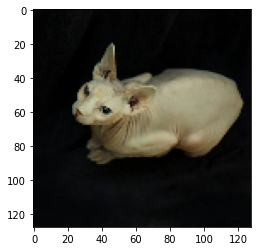

1.0


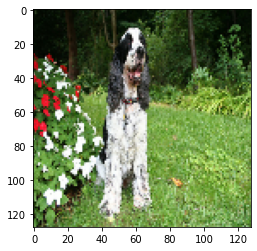

In [22]:
'''Print an image from the train set '''
for img, mask in train.take(2):
  image = img.numpy()
  print(image.max())
  plt.imshow(image)
  plt.show()

dict_keys(['file_name', 'image', 'label', 'segmentation_mask', 'species'])
(500, 500, 3)
(500, 500, 3) uint8


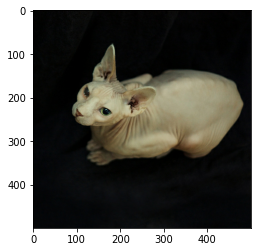

dict_keys(['file_name', 'image', 'label', 'segmentation_mask', 'species'])
(313, 500, 3)
(313, 500, 3) uint8


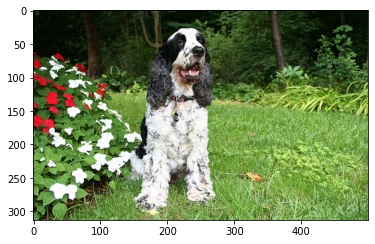

In [0]:
'''Print an image from the dataset - before the transformation'''
# Check the keys
for i in dataset['train'].take(2):
  print(i.keys())
  print(list(i.values())[1].shape)
  img = list(i.values())[1].numpy()

  print(img.shape, img.dtype)
  plt.imshow(img)
  plt.show()

In [20]:
"""
cache():  Caches the elements in this dataset.
The first time the dataset is iterated over, 
its elements will be cached either in the specified file or in memory. 
Subsequent iterations will use the cached data.

The training data get shuffled to omit learning some patterns from the 
training sample order

Last we put the samples in batches
"""
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
# Why we need this at the end?? .repeat()
train_dataset.take(1)

<DatasetV1Adapter shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>

In [21]:
# Some information about Mask and Image after the last preprocessing step

start_time = time.time()

print('NOTE: Here we are taking 2 batches with 64 samples each - so the loop goes 2 times')
for image, mask in train_dataset.take(2):
  print()
  print(mask.shape)
  print()
  print('The samples taken are each time different due to the shuffle')
  print(tf.reduce_max(image), tf.reduce_mean(image))
  print(tf.reduce_max(mask), tf.reduce_mean(mask))
  print('------')

end_time = time.time()
# Print elapsed time
time_elapsed = end_time - start_time
print(time_elapsed)

NOTE: Here we are taking 2 batches with 64 samples each - so the loop goes 2 times

(64, 128, 128, 1)

The samples taken are each time different due to the shuffle
tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.4419589, shape=(), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32) tf.Tensor(0.82250184, shape=(), dtype=float32)
------

(64, 128, 128, 1)

The samples taken are each time different due to the shuffle
tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.40909234, shape=(), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32) tf.Tensor(0.80141747, shape=(), dtype=float32)
------
3.3142595291137695


In [0]:
'''Creates a Dataset that prefetches elements from this dataset.
    we can check the speed of showing the element to comapre the two datasets
    if we instead of replacing train_dataset create a new one'''
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [0]:
test_dataset = test.batch(BATCH_SIZE)

Take a look at some images and masks

In [0]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

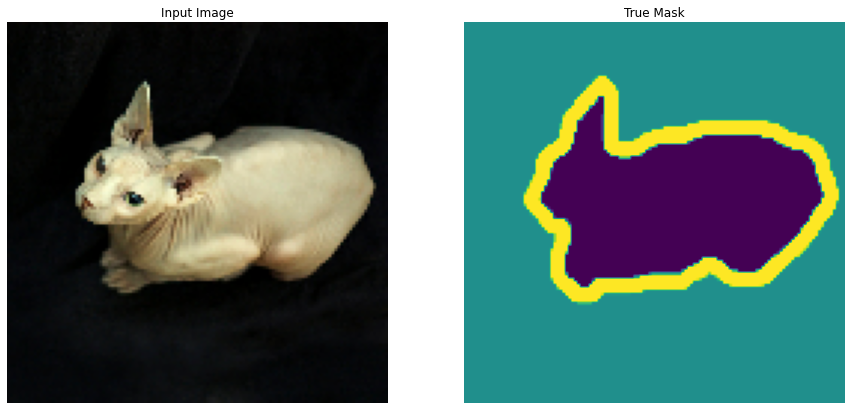

'Why despite normalization the images look as not normalized??\n- maybe matplotlib scale it back???'

In [25]:
# Within the loop we are assining the values from the dict to 
# variables which we are calling afterwards
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
  
display([sample_image, sample_mask])

"""Why despite normalization the images look as not normalized??
- maybe matplotlib scale it back???"""

# Define the model

The model being used here is a modified U-Net. A U-Net consists of an encoder (downsampler) and decoder (upsampler). In-order to learn robust features, and reduce the number of trainable parameters, a pretrained model can be used as the encoder. Thus, the encoder for this task will be a pretrained MobileNetV2 model, whose intermediate outputs will be used, and the decoder will be the upsample block already implemented in TensorFlow Examples in the Pix2pix tutorial.

The OUTPUT_CHANNELS depends on the number of objects we are trying to detect. If we have 1 Object - we have a background, object and an object boarder

In [0]:
OUTPUT_CHANNELS = 3

**Important:** we need to have checked first the output of each layer

In [30]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [28]:

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


The decoder/upsampler is simply a series of upsample blocks implemented in TensorFlow examples.



In [0]:
def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
  """Upsamples an input.
  Conv2DTranspose => Batchnorm => Dropout => Relu
  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_dropout: If True, adds the dropout layer
  Returns:
    Upsample Sequential Model
  """

  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

  if norm_type.lower() == 'batchnorm':
    result.add(tf.keras.layers.BatchNormalization())
  elif norm_type.lower() == 'instancenorm':
    result.add(InstanceNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [0]:
# check that again, expetially the parameter passed

up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),   # 32x32 -> 64x64
]

In [0]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x) # here the result are 5 outputs wiht 64 samples in each
                        # one (batch size)
  x = skips[-1]         # we take output from the first layer (64x4x4x320)

  skips = reversed(skips[:-1])
                        # reverse the skips without its last output
                        # so 8x8, 16x16, 32x32, 64x64

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x) # we upscale first the output we have taken previously 4x4
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip]) # than we concat the previously upscaled output with
                          # with the output of the next layer
                          # this have the form 64x64x64x(160 channels)

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128
        # where the filter numbers stay for the 3 values a pixel can have

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [0]:
def zzz(output_chanels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips2 = reversed(skips[:-1])

  return tf.keras.Model(inputs=inputs, outputs=skips), tf.keras.Model(inputs=inputs, outputs=x)

# Check intermediate results of the model in order to understand it

In [0]:
# model = unet_model(OUTPUT_CHANNELS)
model1, model2 = zzz(OUTPUT_CHANNELS)
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

"""LOSS: The labels are not one-hot encoded (this are just the mask pixel values
thus we are using Sparse loss function"""

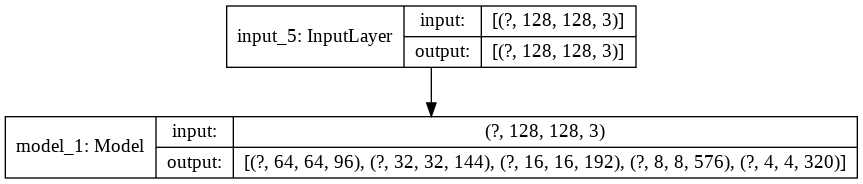

In [0]:
tf.keras.utils.plot_model(model1, show_shapes=True)

In [0]:
for image, mask in train_dataset.take(1):
  pred_mask = model1.predict(image)

print(len(pred_mask))
pred_mask[0].shape

5


(64, 64, 64, 96)

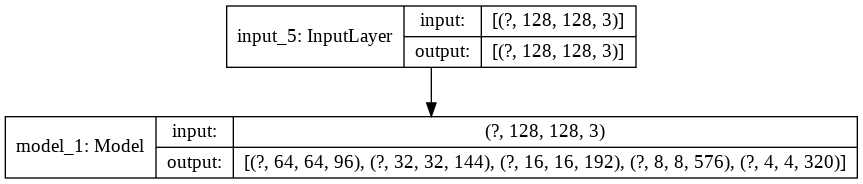

In [0]:
tf.keras.utils.plot_model(model2, show_shapes=True)

In [0]:
for image, mask in train_dataset.take(1):
  pred_mask = model2.predict(image)

print(len(pred_mask))
pred_mask[1].shape

64


(4, 4, 320)

That is the reverse step in the function:

In [0]:
for image, mask in train_dataset.take(1):
  pred_mask = model1.predict(image)

print(len(pred_mask))
pred_mask[0].shape

dd = reversed(pred_mask[:-1])
print(list(dd)[1].shape)

5
(64, 16, 16, 192)


# Understand the Output

The loss being used here is losses.SparseCategoricalCrossentropy(from_logits=True). The reason to use this loss function is because the network is trying to assign each pixel a label, just like multi-class prediction. In the true segmentation mask, each pixel has either a {0,1,2}. The network here is outputting three channels. Essentially, each channel is trying to learn to predict a class, and losses.SparseCategoricalCrossentropy(from_logits=True) is the recommended loss for such a scenario. Using the output of the network, the label assigned to the pixel is the channel with the highest value. This is what the create_mask function is doing

In [35]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

"""Note: 
from_logits=True since no Softmax ix applied to the output of our
model sofar.

Sparse loss since the labels are not one-hot encoded
"""

'Note: \nfrom_logits=True since no Softmax ix applied to the output of our\nmodel sofar.\n\nSparse loss since the labels are not one-hot encoded\n'

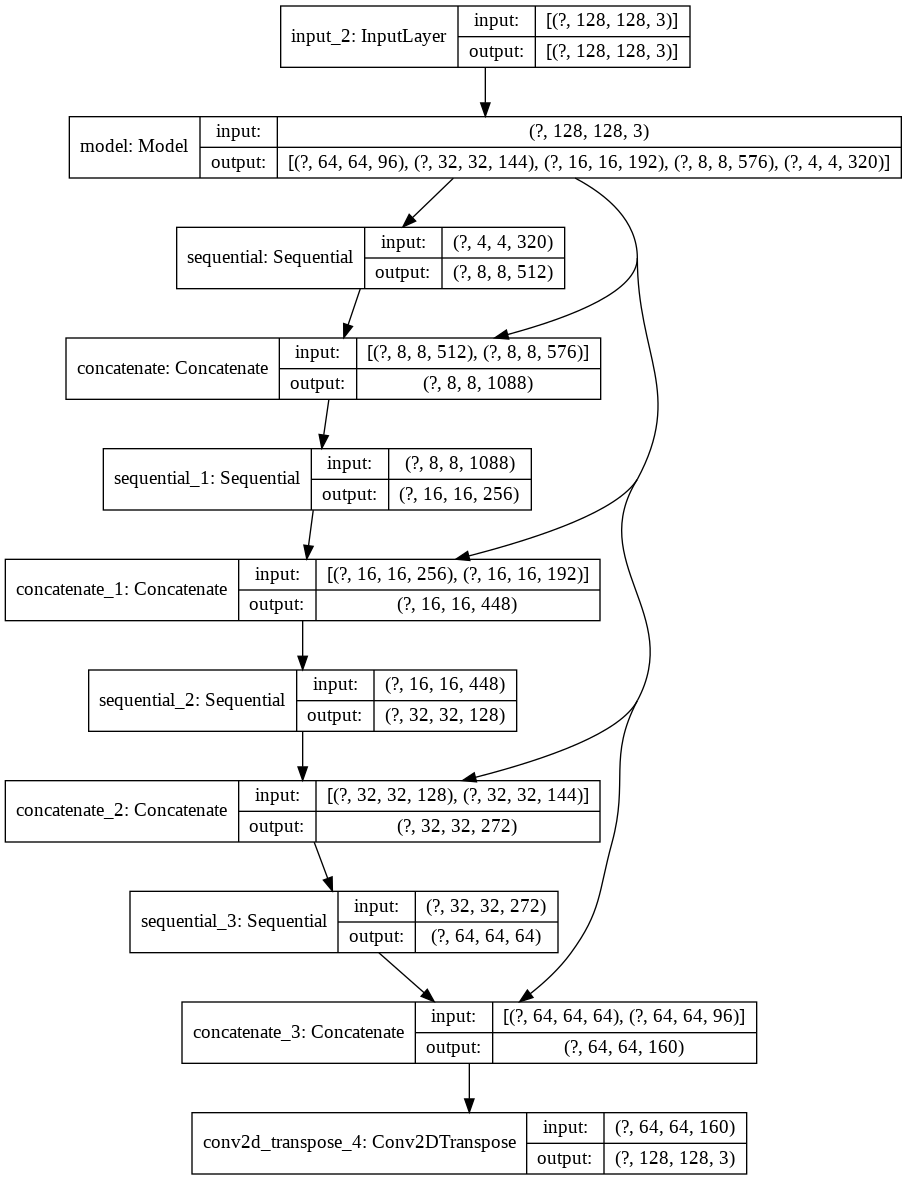

In [0]:
tf.keras.utils.plot_model(model, show_shapes=True)

Understand the output

In [39]:
"""The output are 64 masks"""
for image, mask in train_dataset.take(1):
  pred_mask = model.predict(image)

print('Shape of the output: {}'.format(pred_mask.shape))
print('Maximum value of a predicted mask pixel: {}'.format(pred_mask[0][:,:,0].max()))

Shape of the output: (64, 128, 128, 3)
Maximum value of a predicted mask pixel: 1.576674461364746


In [0]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [41]:
mask = create_mask(pred_mask)
mask.shape

TensorShape([128, 128, 1])

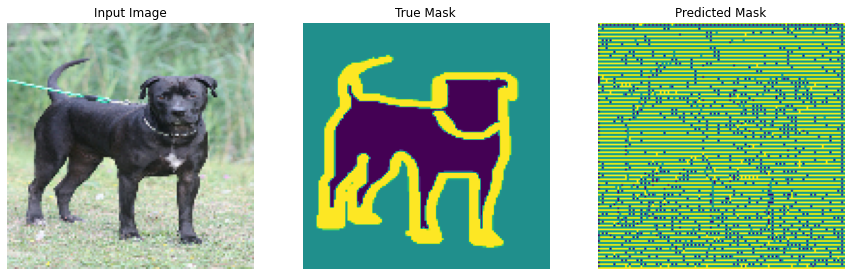

In [42]:
for image, mask in train_dataset.take(1):
  pred_mask = model.predict(image)
  display([image[0], mask[0], create_mask(pred_mask)])

In [0]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [0]:
# Callback Function to show image result on epoch

In [44]:
info.splits['test'].num_examples

3669

In [0]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions(test_dataset) # The dataset on which we are checking 
                                   # the predictions
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

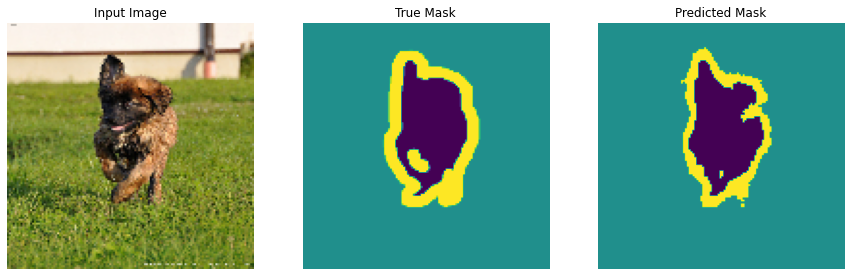


Sample Prediction after epoch 20

57/57 [==============================] - 9s 167ms/step - loss: 0.1377 - accuracy: 0.9372 - val_loss: 0.3211 - val_accuracy: 0.8890


In [46]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch = STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data = test_dataset,
                          callbacks=[DisplayCallback()])

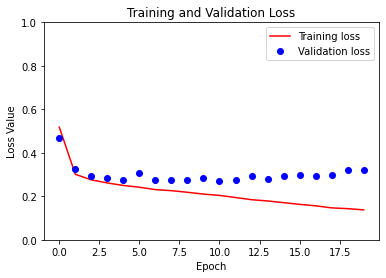

In [47]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

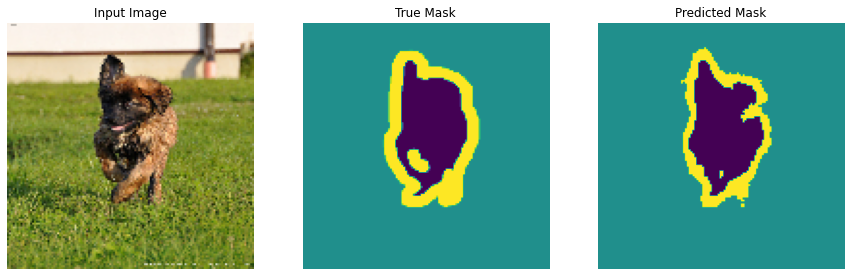

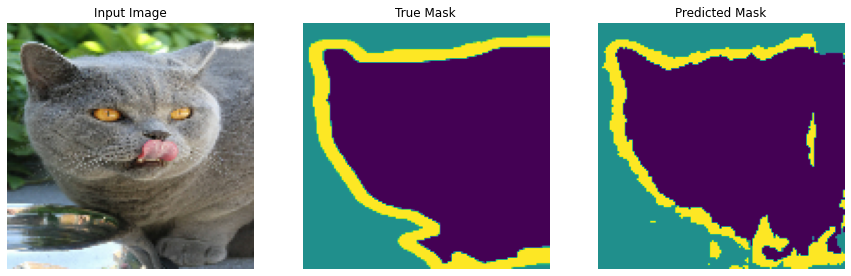

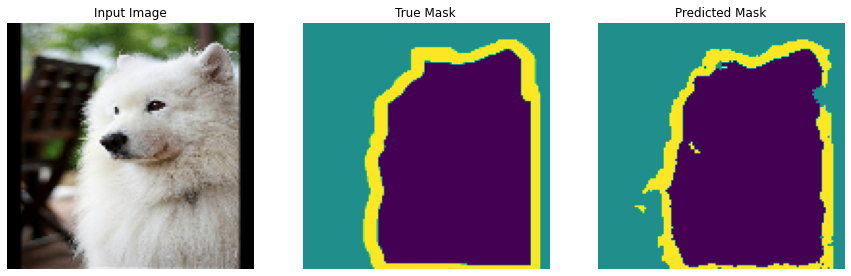

In [48]:
show_predictions(test_dataset, 3)

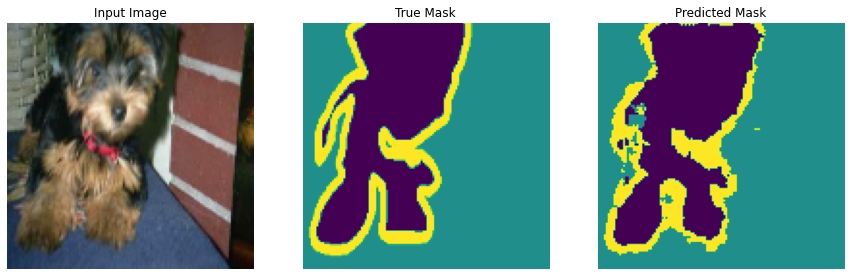

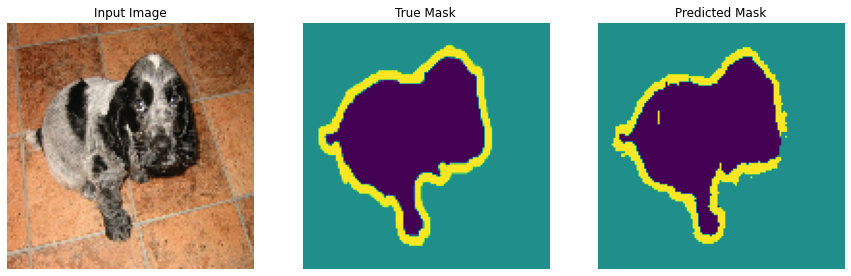

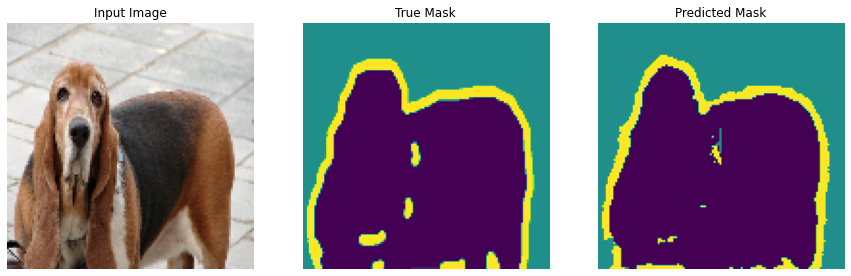

In [49]:
show_predictions(train_dataset, 3)